In [38]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

### Ustawienie parametrów

In [39]:
SEED = 42
MODEL_PATH = "./final_models/best_xgboost_model.pkl"
os.makedirs("final_models", exist_ok=True)

df = pd.read_csv("../data/final_data.csv", sep=';')
df = df[df["price"] > 0]

### Inżynieria cech
Dodajemy nowe kolumny w celu poprawy działania modelu

In [40]:
def haversine(lat1, lon1, lat2, lon2):
    from math import radians, cos, sin, asin, sqrt
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    return R * c

def add_features(data, cheap_thresh, premium_thresh):
    data = data.copy()
    data["is_cheap"] = (data["price"] <= cheap_thresh).astype(int)
    data["is_premium"] = (data["price"] > premium_thresh).astype(int)
    data["distance_to_center"] = data.apply(lambda row: haversine(row["latitude"], row["longitude"], 41.387, 2.170), axis=1)
    data["people_per_bed"] = data["accommodates"] / (data["beds"] + 0.1)
    data["people_per_bedroom"] = data["accommodates"] / (data["bedrooms"] + 0.1)
    amenity_cols = [col for col in data.columns if col.startswith("amenity_")]
    data["num_amenities"] = data[amenity_cols].sum(axis=1)
    data["room_privacy_level"] = (
        data.get("room_type_Shared room", 0) * 0 +
        data.get("room_type_Private room", 0) * 1 +
        data.get("room_type_Entire home/apt", 0) * 2 +
        data.get("room_type_Hotel room", 0) * 2
    )
    data["many_bedrooms"] = (data["bedrooms"] >= 3).astype(int)
    data["few_bathrooms"] = (data["bathrooms_num"] <= 1).astype(int)
    return data

### Szukanie najlepszych progów
Znajdujemy progi `taniego` i `drogiego` mieszkania. 
Potem tworzymy model.

In [41]:

best_r2 = -np.inf
best_model = None
best_features = None
best_cheap = None
best_premium = None

for cheap in range(200, 800, 50):
    for premium in range(900, 1600, 50):
        temp_df = add_features(df, cheap, premium)
        y_temp = np.log1p(temp_df["price"])
        drop_cols = ["id", "price"]
        features = [col for col in temp_df.columns if col not in drop_cols and pd.api.types.is_numeric_dtype(temp_df[col])]
        X_temp = temp_df[features]
        X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED)
        model = XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            random_state=SEED, n_jobs=-1, verbosity=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))
        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_features = features
            best_cheap = cheap
            best_premium = premium


### Ewaluacja najlepszego modelu

In [42]:
final_df = add_features(df, best_cheap, best_premium)
X = final_df[best_features]
y = np.log1p(final_df["price"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

print("MAE: ", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:  ", round(r2, 4))
print(f"Użyte thresholdy: is_cheap <= {best_cheap}, is_premium > {best_premium}")


MAE:  63.15
RMSE: 182.1
R²:   0.897
Użyte thresholdy: is_cheap <= 350, is_premium > 1550


### Zapis modelu, jeśli jest lepszy niż poprzedni
Patrzymy czy RMSE się poprawiło

In [43]:
def load_prev_rmse(path):
    if os.path.exists(path + ".meta"):
        meta = joblib.load(path + ".meta")
        return meta.get("rmse", float("inf"))
    return float("inf")

if rmse < load_prev_rmse(MODEL_PATH):
    joblib.dump(best_model, MODEL_PATH)
    joblib.dump({
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "features": best_features,
        "is_cheap_threshold": best_cheap,
        "is_premium_threshold": best_premium
    }, MODEL_PATH + ".meta")
    print("Zapisano nowy najlepszy model do", MODEL_PATH)


Zapisano nowy najlepszy model do ./final_models/best_xgboost_model.pkl


### Wykresy

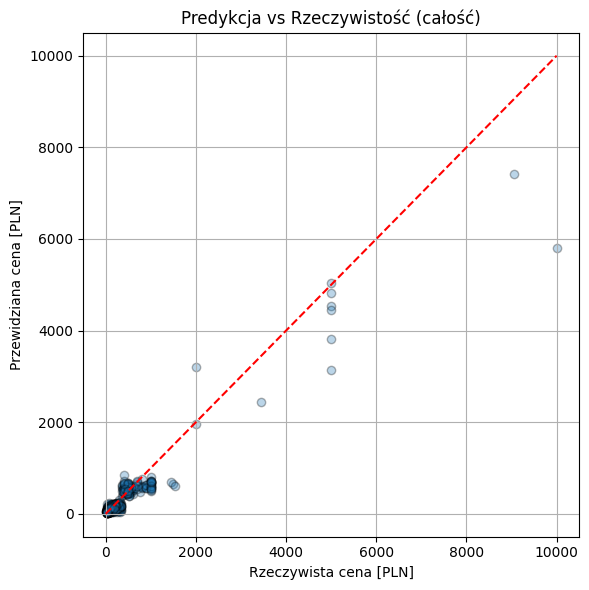

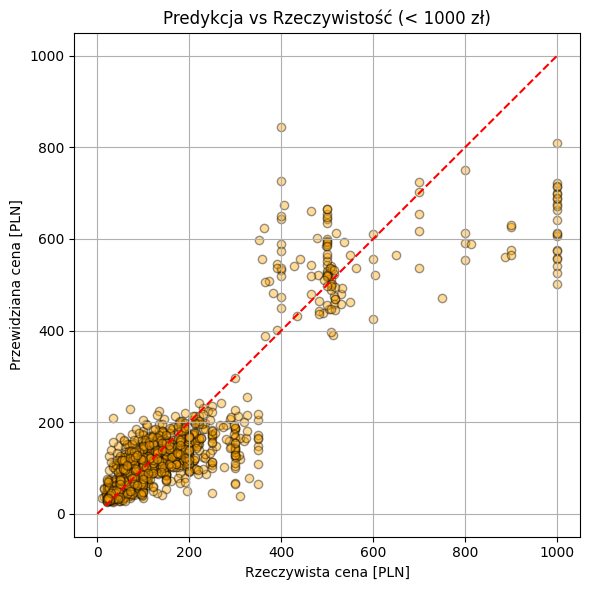

In [44]:
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.3, edgecolor='k')
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel("Rzeczywista cena [PLN]")
plt.ylabel("Przewidziana cena [PLN]")
plt.title("Predykcja vs Rzeczywistość (całość)")
plt.grid(True)
plt.tight_layout()
plt.show()

mask = np.expm1(y_test) < 1000
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test[mask]), np.expm1(y_pred[mask]), alpha=0.4, edgecolor='k', color='orange')
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel("Rzeczywista cena [PLN]")
plt.ylabel("Przewidziana cena [PLN]")
plt.title("Predykcja vs Rzeczywistość (< 1000 zł)")
plt.grid(True)
plt.tight_layout()
plt.show()